In [1]:
pip install mxnet gluonts ujson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 113 kB/s 
     |████████████████████████████████| 1.0 MB 54.2 MB/s 
     |████████████████████████████████| 52 kB 469 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("BTC-USD.csv")
df = df.loc[:, ['Date', 'Close']]
df.head()

,Date,Close
0,2017-11-05,7407.410156
1,2017-11-06,7022.759766
2,2017-11-07,7144.379883
3,2017-11-08,7459.689941
4,2017-11-09,7143.580078


In [5]:
df.columns = ["Date","Close"]

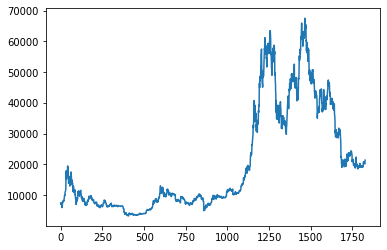

In [6]:
df["Close"].plot()

In [7]:
df = df[:-1]
df.Date = pd.to_datetime(df.Date)
df.set_index("Date",drop=True, inplace=True)
df.tail()

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Close
Date,
2022-10-31,20495.773438
2022-11-01,20485.273438
2022-11-02,20159.503906
2022-11-03,20209.988281
2022-11-04,21147.230469


In [8]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

In [9]:
training_data = ListDataset(
    [{"start": df.index[0], "target": df.Close[:"2022-12-01T00:00:00.000000"], }],
    freq = "M"
)

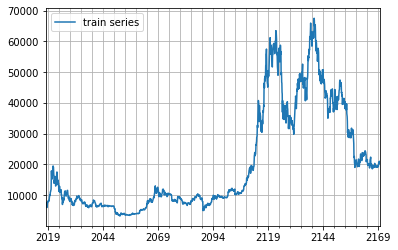

In [10]:
entry = next(iter(training_data))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
# plt.title(entry['item_id'])
plt.show()

In [11]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions


/usr/local/lib/python3.8/dist-packages/gluonts/model/deepar/__init__.py:18: FutureWarning: The module gluonts.model.deepar has been moved to gluonts.mx.model.deepar. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import DeepAREstimator'.
  warnings.warn(


In [12]:
callbacks = [
    LearningRateReduction(objective="min",
                          patience=10,
                          base_lr=1e-3,
                          decay_factor=0.5,
                          ),
    ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
]


estimator = DeepAREstimator(
    freq="M",
    prediction_length=24,
    context_length=36,
    num_layers = 2,
    num_cells = 40,
    distr_output=StudentTOutput(),
    dropout_rate=0.01,
    trainer=Trainer(#ctx = mx.context.gpu(),
                    epochs=500,
                    callbacks=callbacks))

predictor = estimator.train(training_data)

100%|██████████| 50/50 [00:05<00:00,  9.96it/s, epoch=500/500, avg_epoch_loss=7.45]


In [13]:
# Test data
test_data = ListDataset(
    [{"start": df.index[0], "target": df.Close[:"2022-12-01T00:00:00.000000"]}],
    freq = "M"
)

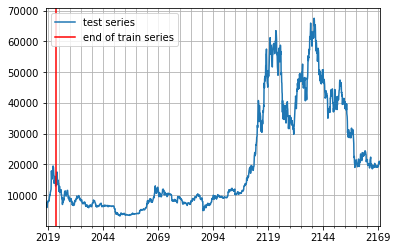

In [14]:
entry = next(iter(test_data))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(df.index[-24], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
# plt.title(entry['item_id'])
plt.show()

In [15]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

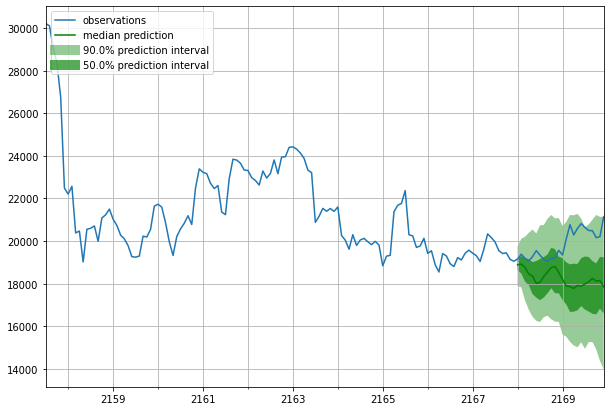

In [16]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [17]:
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

import json
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 25.24it/s]

{
    "MSE": 3301100.0,
    "abs_error": 37754.03125,
    "abs_target_sum": 476132.75,
    "abs_target_mean": 19838.864583333332,
    "seasonal_error": 2200.4539106145253,
    "MASE": 0.7148909721891644,
    "MAPE": 0.0778008649746577,
    "sMAPE": 0.08213900029659271,
    "MSIS": 3.0239375267767885,
    "QuantileLoss[0.1]": 16794.5404296875,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.2]": 27533.353906250002,
    "Coverage[0.2]": 0.0,
    "QuantileLoss[0.3]": 32743.597265624998,
    "Coverage[0.3]": 0.0,
    "QuantileLoss[0.4]": 36901.0953125,
    "Coverage[0.4]": 0.0,
    "QuantileLoss[0.5]": 37754.03125,
    "Coverage[0.5]": 0.0,
    "QuantileLoss[0.6]": 35826.54609375,
    "Coverage[0.6]": 0.0,
    "QuantileLoss[0.7]": 29649.003906249996,
    "Coverage[0.7]": 0.125,
    "QuantileLoss[0.8]": 21870.934375000004,
    "Coverage[0.8]": 0.4583333333333333,
    "QuantileLoss[0.9]": 7921.048828125,
    "Coverage[0.9]": 0.6666666666666666,
    "RMSE": 1816.8929522676892,
    "NRMSE": 0.09